In [5]:
import torch
import clip
from PIL import Image

In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset = datasets.ImageFolder(
    root="data",
    transform=preprocess
)

# DataLoader for batching
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [41]:
import matplotlib.pyplot as plt


all_embeddings = []
with torch.no_grad():
    for images, _ in dataloader:  # we ignore class labels
        images = images.to(device)
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)
        all_embeddings.append(features)

embeddings = torch.cat(all_embeddings, dim=0)

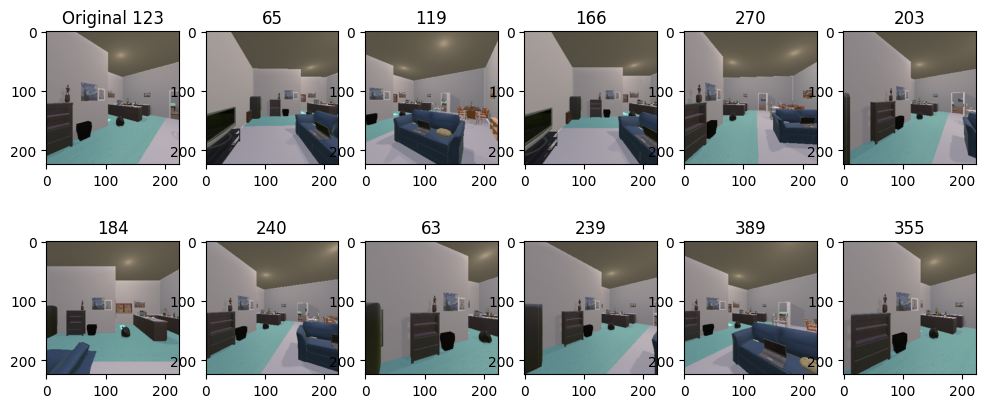

In [101]:
embeddings_norm = embeddings / torch.norm(embeddings, dim=1, keepdim=True)

query_idx = torch.randint(0, len(dataset), (1,))[0]
query = embeddings_norm[query_idx]
similarities = embeddings_norm @ query  # shape (N,)

k = 11
topk_idx = similarities.argsort()[-k-1:-1]

CLIP_MEAN = torch.tensor([0.48145466, 0.4578275, 0.40821073])
CLIP_STD  = torch.tensor([0.26862954, 0.26130258, 0.27577711])

def denormalize(tensor):
    """
    Undo CLIP preprocessing normalization.
    Input: torch tensor of shape (3, H, W)
    Output: numpy array in [0,1] range
    """
    img = tensor * CLIP_STD[:, None, None] + CLIP_MEAN[:, None, None]
    img = torch.clamp(img, 0, 1)
    return img.permute(1, 2, 0).cpu().numpy()

image, _ = dataset[query_idx]
i = 1
plt.figure(figsize=(k + 1,5))
plt.subplot(2, int((k + 1) / 2), i)
plt.imshow(denormalize(image))
plt.title(f"Original {query_idx}")
i += 1
for idx in topk_idx:
    plt.subplot(2, int((k + 1) / 2), i)
    image, _ = dataset[idx]
    plt.imshow(denormalize(image))
    plt.title(str(idx.item()))
    i += 1
plt.show()